In [30]:
import pandas as pd
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import transformers
from tensorflow.keras.models import Model
from keras.layers.core import Dense, Dropout
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
import matplotlib.pyplot as plt
import numpy as np

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.0.0.2:8470


In [5]:
train = pd.read_csv('../input/dataset-modified/train_modified.csv')
valid = pd.read_csv('../input/dataset-modified/val_modified.csv')
test = pd.read_csv('../input/dataset-modified/test_modified.csv')

xtrain, ytrain = train.Comment.values, train.Emotion.values
xvalid, yvalid = valid.Comment.values, valid.Emotion.values
xtest, ytest = test.Comment.values, test.Emotion.values

In [7]:
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = 'bert-base-multilingual-cased')
max_len = 200

xtrain_pad = tokenizer(
    text=train['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

xvalid_pad = tokenizer(
    text=valid['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

In [8]:
def build_model(transformer):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    sequence_output = transformer(input_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(4, activation='softmax')(cls_token)

    model = Model(inputs=input_ids, outputs=out)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(Adam(lr=1e-5, beta_2 = 0.99), loss=loss, metrics=['accuracy'])

    return model

In [48]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

with strategy.scope():
    model_name = 'bert-base-multilingual-cased'
    config = BertConfig.from_pretrained(model_name)
    config.output_hidden_states = False
    transformer_model = TFBertModel.from_pretrained(model_name, config = config)
    model = build_model(transformer_model)
    
model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
tf_bert_model_3 (TFBertModel ((None, 200, 768), (None, 177853440 
_________________________________________________________________
tf_op_layer_strided_slice_3  [(None, 768)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 3076      
Total params: 177,856,516
Trainable params: 177,856,516
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = model.fit(xtrain_pad['input_ids'], ytrain,epochs=100, validation_data= (xvalid_pad['input_ids'], yvalid), batch_size=128) 

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 1.3872 - accuracy: 0.22 - ETA: 1s - loss: 1.3871 - accuracy: 0.23 - ETA: 2s - loss: 1.3856 - accuracy: 0.25 - ETA: 2s - loss: 1.3868 - accuracy: 0.25 - ETA: 2s - loss: 1.3968 - accuracy: 0.24 - ETA: 2s - loss: 1.3942 - accuracy: 0.25 - ETA: 2s - loss: 1.3921 - accuracy: 0.25 - ETA: 2s - loss: 1.3894 - accuracy: 0.26 - ETA: 2s - loss: 1.3879 - accuracy: 0.26 - ETA: 1s - loss: 1.3852 - accuracy: 0.27 - ETA: 1s - loss: 1.3828 - accuracy: 0.27 - ETA: 1s - loss: 1.3808 - accuracy: 0.28 - ETA: 1s - loss: 1.3822 - accuracy: 0.28 - ETA: 1s - loss: 1.3829 - accuracy: 0.28 - ETA: 1s - loss: 1.3819 - accuracy: 0.28 - ETA: 1s - loss: 1.3792 - accuracy: 0.29 - ETA: 0s - loss: 1.3763 - accuracy: 0.29 - ETA: 0s - loss: 1.3737 - accuracy: 0.30 - ETA: 0s - loss: 1.3718 - accuracy: 0.30 - ETA: 0s - loss: 1.3707 - accuracy: 0.30 - ETA: 0s - loss: 1.3685 - accuracy: 0.30 - ETA: 0s - loss: 1.3656 - accuracy: 0.31 - ETA: 0s - loss: 1.3609 

24/24 [==============================] - ETA: 0s - loss: 0.8655 - accuracy: 0.88 - ETA: 1s - loss: 0.8694 - accuracy: 0.87 - ETA: 2s - loss: 0.8900 - accuracy: 0.85 - ETA: 2s - loss: 0.8899 - accuracy: 0.85 - ETA: 2s - loss: 0.8857 - accuracy: 0.85 - ETA: 2s - loss: 0.8864 - accuracy: 0.85 - ETA: 2s - loss: 0.8881 - accuracy: 0.85 - ETA: 2s - loss: 0.8912 - accuracy: 0.85 - ETA: 2s - loss: 0.8884 - accuracy: 0.85 - ETA: 1s - loss: 0.8870 - accuracy: 0.85 - ETA: 1s - loss: 0.8887 - accuracy: 0.85 - ETA: 1s - loss: 0.8867 - accuracy: 0.85 - ETA: 1s - loss: 0.8853 - accuracy: 0.85 - ETA: 1s - loss: 0.8831 - accuracy: 0.86 - ETA: 1s - loss: 0.8837 - accuracy: 0.86 - ETA: 1s - loss: 0.8855 - accuracy: 0.85 - ETA: 0s - loss: 0.8854 - accuracy: 0.85 - ETA: 0s - loss: 0.8859 - accuracy: 0.85 - ETA: 0s - loss: 0.8865 - accuracy: 0.85 - ETA: 0s - loss: 0.8876 - accuracy: 0.85 - ETA: 0s - loss: 0.8871 - accuracy: 0.85 - ETA: 0s - loss: 0.8865 - accuracy: 0.85 - ETA: 0s - loss: 0.8873 - accuracy: 

24/24 [==============================] - ETA: 0s - loss: 0.8205 - accuracy: 0.92 - ETA: 1s - loss: 0.8277 - accuracy: 0.92 - ETA: 2s - loss: 0.8304 - accuracy: 0.91 - ETA: 2s - loss: 0.8264 - accuracy: 0.91 - ETA: 2s - loss: 0.8303 - accuracy: 0.91 - ETA: 2s - loss: 0.8327 - accuracy: 0.91 - ETA: 2s - loss: 0.8360 - accuracy: 0.91 - ETA: 2s - loss: 0.8366 - accuracy: 0.91 - ETA: 1s - loss: 0.8326 - accuracy: 0.91 - ETA: 1s - loss: 0.8305 - accuracy: 0.91 - ETA: 1s - loss: 0.8313 - accuracy: 0.91 - ETA: 1s - loss: 0.8307 - accuracy: 0.91 - ETA: 1s - loss: 0.8273 - accuracy: 0.91 - ETA: 1s - loss: 0.8281 - accuracy: 0.91 - ETA: 1s - loss: 0.8266 - accuracy: 0.91 - ETA: 1s - loss: 0.8271 - accuracy: 0.91 - ETA: 0s - loss: 0.8288 - accuracy: 0.91 - ETA: 0s - loss: 0.8270 - accuracy: 0.91 - ETA: 0s - loss: 0.8263 - accuracy: 0.91 - ETA: 0s - loss: 0.8279 - accuracy: 0.91 - ETA: 0s - loss: 0.8285 - accuracy: 0.91 - ETA: 0s - loss: 0.8301 - accuracy: 0.91 - ETA: 0s - loss: 0.8284 - accuracy: 

24/24 [==============================] - ETA: 0s - loss: 0.8019 - accuracy: 0.94 - ETA: 1s - loss: 0.8040 - accuracy: 0.94 - ETA: 2s - loss: 0.8035 - accuracy: 0.94 - ETA: 2s - loss: 0.8043 - accuracy: 0.94 - ETA: 2s - loss: 0.8006 - accuracy: 0.94 - ETA: 2s - loss: 0.7992 - accuracy: 0.94 - ETA: 2s - loss: 0.8032 - accuracy: 0.94 - ETA: 2s - loss: 0.7991 - accuracy: 0.94 - ETA: 1s - loss: 0.8012 - accuracy: 0.94 - ETA: 1s - loss: 0.8029 - accuracy: 0.94 - ETA: 1s - loss: 0.8061 - accuracy: 0.94 - ETA: 1s - loss: 0.8046 - accuracy: 0.94 - ETA: 1s - loss: 0.8044 - accuracy: 0.94 - ETA: 1s - loss: 0.8046 - accuracy: 0.94 - ETA: 1s - loss: 0.8048 - accuracy: 0.94 - ETA: 1s - loss: 0.8054 - accuracy: 0.93 - ETA: 0s - loss: 0.8044 - accuracy: 0.94 - ETA: 0s - loss: 0.8041 - accuracy: 0.94 - ETA: 0s - loss: 0.8028 - accuracy: 0.94 - ETA: 0s - loss: 0.8046 - accuracy: 0.94 - ETA: 0s - loss: 0.8026 - accuracy: 0.94 - ETA: 0s - loss: 0.8046 - accuracy: 0.94 - ETA: 0s - loss: 0.8034 - accuracy: 

24/24 [==============================] - ETA: 0s - loss: 0.8528 - accuracy: 0.88 - ETA: 1s - loss: 0.8192 - accuracy: 0.92 - ETA: 2s - loss: 0.8078 - accuracy: 0.93 - ETA: 2s - loss: 0.8054 - accuracy: 0.93 - ETA: 2s - loss: 0.7962 - accuracy: 0.94 - ETA: 2s - loss: 0.7907 - accuracy: 0.95 - ETA: 2s - loss: 0.7950 - accuracy: 0.94 - ETA: 2s - loss: 0.7983 - accuracy: 0.94 - ETA: 2s - loss: 0.7946 - accuracy: 0.94 - ETA: 1s - loss: 0.7964 - accuracy: 0.94 - ETA: 1s - loss: 0.7956 - accuracy: 0.94 - ETA: 1s - loss: 0.7952 - accuracy: 0.94 - ETA: 1s - loss: 0.7957 - accuracy: 0.94 - ETA: 1s - loss: 0.7950 - accuracy: 0.94 - ETA: 1s - loss: 0.7935 - accuracy: 0.95 - ETA: 1s - loss: 0.7934 - accuracy: 0.95 - ETA: 1s - loss: 0.7936 - accuracy: 0.94 - ETA: 0s - loss: 0.7938 - accuracy: 0.94 - ETA: 0s - loss: 0.7942 - accuracy: 0.94 - ETA: 0s - loss: 0.7934 - accuracy: 0.95 - ETA: 0s - loss: 0.7936 - accuracy: 0.94 - ETA: 0s - loss: 0.7928 - accuracy: 0.95 - ETA: 0s - loss: 0.7918 - accuracy: 

24/24 [==============================] - ETA: 0s - loss: 0.7599 - accuracy: 0.97 - ETA: 1s - loss: 0.7568 - accuracy: 0.98 - ETA: 2s - loss: 0.7696 - accuracy: 0.97 - ETA: 2s - loss: 0.7669 - accuracy: 0.97 - ETA: 2s - loss: 0.7686 - accuracy: 0.97 - ETA: 2s - loss: 0.7703 - accuracy: 0.97 - ETA: 2s - loss: 0.7732 - accuracy: 0.96 - ETA: 2s - loss: 0.7762 - accuracy: 0.96 - ETA: 2s - loss: 0.7814 - accuracy: 0.96 - ETA: 1s - loss: 0.7816 - accuracy: 0.96 - ETA: 1s - loss: 0.7810 - accuracy: 0.96 - ETA: 1s - loss: 0.7817 - accuracy: 0.96 - ETA: 1s - loss: 0.7806 - accuracy: 0.96 - ETA: 1s - loss: 0.7802 - accuracy: 0.96 - ETA: 1s - loss: 0.7822 - accuracy: 0.96 - ETA: 1s - loss: 0.7812 - accuracy: 0.96 - ETA: 0s - loss: 0.7813 - accuracy: 0.96 - ETA: 0s - loss: 0.7830 - accuracy: 0.96 - ETA: 0s - loss: 0.7831 - accuracy: 0.96 - ETA: 0s - loss: 0.7830 - accuracy: 0.96 - ETA: 0s - loss: 0.7830 - accuracy: 0.96 - ETA: 0s - loss: 0.7825 - accuracy: 0.96 - ETA: 0s - loss: 0.7828 - accuracy: 

24/24 [==============================] - ETA: 0s - loss: 0.7747 - accuracy: 0.96 - ETA: 1s - loss: 0.7679 - accuracy: 0.97 - ETA: 2s - loss: 0.7755 - accuracy: 0.96 - ETA: 2s - loss: 0.7766 - accuracy: 0.96 - ETA: 2s - loss: 0.7763 - accuracy: 0.96 - ETA: 2s - loss: 0.7813 - accuracy: 0.96 - ETA: 2s - loss: 0.7772 - accuracy: 0.96 - ETA: 2s - loss: 0.7780 - accuracy: 0.96 - ETA: 2s - loss: 0.7776 - accuracy: 0.96 - ETA: 1s - loss: 0.7821 - accuracy: 0.96 - ETA: 1s - loss: 0.7828 - accuracy: 0.96 - ETA: 1s - loss: 0.7825 - accuracy: 0.96 - ETA: 1s - loss: 0.7825 - accuracy: 0.96 - ETA: 1s - loss: 0.7820 - accuracy: 0.96 - ETA: 1s - loss: 0.7825 - accuracy: 0.96 - ETA: 1s - loss: 0.7821 - accuracy: 0.96 - ETA: 1s - loss: 0.7844 - accuracy: 0.95 - ETA: 0s - loss: 0.7842 - accuracy: 0.95 - ETA: 0s - loss: 0.7837 - accuracy: 0.95 - ETA: 0s - loss: 0.7843 - accuracy: 0.95 - ETA: 0s - loss: 0.7830 - accuracy: 0.95 - ETA: 0s - loss: 0.7827 - accuracy: 0.96 - ETA: 0s - loss: 0.7816 - accuracy: 

24/24 [==============================] - ETA: 0s - loss: 0.7750 - accuracy: 0.96 - ETA: 1s - loss: 0.7735 - accuracy: 0.96 - ETA: 2s - loss: 0.7792 - accuracy: 0.96 - ETA: 2s - loss: 0.7851 - accuracy: 0.95 - ETA: 2s - loss: 0.7869 - accuracy: 0.95 - ETA: 2s - loss: 0.7861 - accuracy: 0.95 - ETA: 2s - loss: 0.7868 - accuracy: 0.95 - ETA: 2s - loss: 0.7853 - accuracy: 0.95 - ETA: 2s - loss: 0.7870 - accuracy: 0.95 - ETA: 1s - loss: 0.7834 - accuracy: 0.95 - ETA: 1s - loss: 0.7844 - accuracy: 0.95 - ETA: 1s - loss: 0.7827 - accuracy: 0.95 - ETA: 1s - loss: 0.7816 - accuracy: 0.96 - ETA: 1s - loss: 0.7800 - accuracy: 0.96 - ETA: 1s - loss: 0.7789 - accuracy: 0.96 - ETA: 1s - loss: 0.7786 - accuracy: 0.96 - ETA: 1s - loss: 0.7779 - accuracy: 0.96 - ETA: 0s - loss: 0.7778 - accuracy: 0.96 - ETA: 0s - loss: 0.7791 - accuracy: 0.96 - ETA: 0s - loss: 0.7797 - accuracy: 0.96 - ETA: 0s - loss: 0.7810 - accuracy: 0.96 - ETA: 0s - loss: 0.7804 - accuracy: 0.96 - ETA: 0s - loss: 0.7812 - accuracy: 

24/24 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 1s - loss: 0.7750 - accuracy: 0.96 - ETA: 2s - loss: 0.7706 - accuracy: 0.97 - ETA: 2s - loss: 0.7659 - accuracy: 0.97 - ETA: 2s - loss: 0.7683 - accuracy: 0.97 - ETA: 2s - loss: 0.7720 - accuracy: 0.97 - ETA: 2s - loss: 0.7771 - accuracy: 0.96 - ETA: 2s - loss: 0.7739 - accuracy: 0.96 - ETA: 2s - loss: 0.7760 - accuracy: 0.96 - ETA: 1s - loss: 0.7774 - accuracy: 0.96 - ETA: 1s - loss: 0.7779 - accuracy: 0.96 - ETA: 1s - loss: 0.7771 - accuracy: 0.96 - ETA: 1s - loss: 0.7773 - accuracy: 0.96 - ETA: 1s - loss: 0.7770 - accuracy: 0.96 - ETA: 1s - loss: 0.7775 - accuracy: 0.96 - ETA: 1s - loss: 0.7788 - accuracy: 0.96 - ETA: 0s - loss: 0.7785 - accuracy: 0.96 - ETA: 0s - loss: 0.7784 - accuracy: 0.96 - ETA: 0s - loss: 0.7778 - accuracy: 0.96 - ETA: 0s - loss: 0.7769 - accuracy: 0.96 - ETA: 0s - loss: 0.7766 - accuracy: 0.96 - ETA: 0s - loss: 0.7759 - accuracy: 0.96 - ETA: 0s - loss: 0.7779 - accuracy: 

24/24 [==============================] - ETA: 0s - loss: 0.7662 - accuracy: 0.97 - ETA: 1s - loss: 0.7860 - accuracy: 0.95 - ETA: 2s - loss: 0.7828 - accuracy: 0.96 - ETA: 2s - loss: 0.7810 - accuracy: 0.96 - ETA: 2s - loss: 0.7809 - accuracy: 0.96 - ETA: 2s - loss: 0.7813 - accuracy: 0.96 - ETA: 2s - loss: 0.7786 - accuracy: 0.96 - ETA: 2s - loss: 0.7809 - accuracy: 0.96 - ETA: 1s - loss: 0.7802 - accuracy: 0.96 - ETA: 1s - loss: 0.7812 - accuracy: 0.96 - ETA: 1s - loss: 0.7827 - accuracy: 0.96 - ETA: 1s - loss: 0.7853 - accuracy: 0.95 - ETA: 1s - loss: 0.7855 - accuracy: 0.95 - ETA: 1s - loss: 0.7853 - accuracy: 0.95 - ETA: 1s - loss: 0.7846 - accuracy: 0.95 - ETA: 1s - loss: 0.7832 - accuracy: 0.96 - ETA: 0s - loss: 0.7833 - accuracy: 0.96 - ETA: 0s - loss: 0.7835 - accuracy: 0.96 - ETA: 0s - loss: 0.7842 - accuracy: 0.95 - ETA: 0s - loss: 0.7826 - accuracy: 0.96 - ETA: 0s - loss: 0.7829 - accuracy: 0.96 - ETA: 0s - loss: 0.7825 - accuracy: 0.96 - ETA: 0s - loss: 0.7824 - accuracy: 

24/24 [==============================] - ETA: 0s - loss: 0.7828 - accuracy: 0.96 - ETA: 1s - loss: 0.7741 - accuracy: 0.96 - ETA: 2s - loss: 0.7747 - accuracy: 0.96 - ETA: 2s - loss: 0.7728 - accuracy: 0.97 - ETA: 2s - loss: 0.7702 - accuracy: 0.97 - ETA: 2s - loss: 0.7724 - accuracy: 0.97 - ETA: 2s - loss: 0.7737 - accuracy: 0.96 - ETA: 2s - loss: 0.7710 - accuracy: 0.97 - ETA: 1s - loss: 0.7715 - accuracy: 0.97 - ETA: 1s - loss: 0.7722 - accuracy: 0.97 - ETA: 1s - loss: 0.7717 - accuracy: 0.97 - ETA: 1s - loss: 0.7733 - accuracy: 0.97 - ETA: 1s - loss: 0.7747 - accuracy: 0.96 - ETA: 1s - loss: 0.7764 - accuracy: 0.96 - ETA: 1s - loss: 0.7748 - accuracy: 0.96 - ETA: 1s - loss: 0.7763 - accuracy: 0.96 - ETA: 0s - loss: 0.7762 - accuracy: 0.96 - ETA: 0s - loss: 0.7761 - accuracy: 0.96 - ETA: 0s - loss: 0.7761 - accuracy: 0.96 - ETA: 0s - loss: 0.7772 - accuracy: 0.96 - ETA: 0s - loss: 0.7770 - accuracy: 0.96 - ETA: 0s - loss: 0.7769 - accuracy: 0.96 - ETA: 0s - loss: 0.7772 - accuracy: 

24/24 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 1s - loss: 0.7705 - accuracy: 0.97 - ETA: 2s - loss: 0.7701 - accuracy: 0.97 - ETA: 2s - loss: 0.7694 - accuracy: 0.97 - ETA: 2s - loss: 0.7748 - accuracy: 0.96 - ETA: 2s - loss: 0.7722 - accuracy: 0.97 - ETA: 2s - loss: 0.7718 - accuracy: 0.97 - ETA: 2s - loss: 0.7722 - accuracy: 0.97 - ETA: 2s - loss: 0.7726 - accuracy: 0.97 - ETA: 1s - loss: 0.7743 - accuracy: 0.96 - ETA: 1s - loss: 0.7741 - accuracy: 0.96 - ETA: 1s - loss: 0.7747 - accuracy: 0.96 - ETA: 1s - loss: 0.7757 - accuracy: 0.96 - ETA: 1s - loss: 0.7757 - accuracy: 0.96 - ETA: 1s - loss: 0.7756 - accuracy: 0.96 - ETA: 1s - loss: 0.7756 - accuracy: 0.96 - ETA: 1s - loss: 0.7763 - accuracy: 0.96 - ETA: 0s - loss: 0.7760 - accuracy: 0.96 - ETA: 0s - loss: 0.7751 - accuracy: 0.96 - ETA: 0s - loss: 0.7755 - accuracy: 0.96 - ETA: 0s - loss: 0.7745 - accuracy: 0.96 - ETA: 0s - loss: 0.7739 - accuracy: 0.96 - ETA: 0s - loss: 0.7747 - accuracy: 

24/24 [==============================] - ETA: 0s - loss: 0.7898 - accuracy: 0.95 - ETA: 1s - loss: 0.7748 - accuracy: 0.96 - ETA: 2s - loss: 0.7800 - accuracy: 0.96 - ETA: 2s - loss: 0.7790 - accuracy: 0.96 - ETA: 2s - loss: 0.7781 - accuracy: 0.96 - ETA: 2s - loss: 0.7781 - accuracy: 0.96 - ETA: 2s - loss: 0.7764 - accuracy: 0.96 - ETA: 2s - loss: 0.7782 - accuracy: 0.96 - ETA: 2s - loss: 0.7775 - accuracy: 0.96 - ETA: 1s - loss: 0.7757 - accuracy: 0.96 - ETA: 1s - loss: 0.7755 - accuracy: 0.96 - ETA: 1s - loss: 0.7748 - accuracy: 0.96 - ETA: 1s - loss: 0.7742 - accuracy: 0.96 - ETA: 1s - loss: 0.7748 - accuracy: 0.96 - ETA: 1s - loss: 0.7753 - accuracy: 0.96 - ETA: 1s - loss: 0.7759 - accuracy: 0.96 - ETA: 0s - loss: 0.7750 - accuracy: 0.96 - ETA: 0s - loss: 0.7741 - accuracy: 0.96 - ETA: 0s - loss: 0.7737 - accuracy: 0.96 - ETA: 0s - loss: 0.7730 - accuracy: 0.97 - ETA: 0s - loss: 0.7742 - accuracy: 0.96 - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 0s - loss: 0.7757 - accuracy: 

24/24 [==============================] - ETA: 0s - loss: 0.7593 - accuracy: 0.98 - ETA: 1s - loss: 0.7631 - accuracy: 0.98 - ETA: 2s - loss: 0.7696 - accuracy: 0.97 - ETA: 2s - loss: 0.7670 - accuracy: 0.97 - ETA: 2s - loss: 0.7674 - accuracy: 0.97 - ETA: 2s - loss: 0.7661 - accuracy: 0.97 - ETA: 2s - loss: 0.7662 - accuracy: 0.97 - ETA: 2s - loss: 0.7722 - accuracy: 0.97 - ETA: 1s - loss: 0.7726 - accuracy: 0.97 - ETA: 1s - loss: 0.7744 - accuracy: 0.96 - ETA: 1s - loss: 0.7758 - accuracy: 0.96 - ETA: 1s - loss: 0.7759 - accuracy: 0.96 - ETA: 1s - loss: 0.7744 - accuracy: 0.96 - ETA: 1s - loss: 0.7726 - accuracy: 0.97 - ETA: 1s - loss: 0.7736 - accuracy: 0.96 - ETA: 1s - loss: 0.7741 - accuracy: 0.96 - ETA: 0s - loss: 0.7728 - accuracy: 0.97 - ETA: 0s - loss: 0.7729 - accuracy: 0.97 - ETA: 0s - loss: 0.7730 - accuracy: 0.97 - ETA: 0s - loss: 0.7723 - accuracy: 0.97 - ETA: 0s - loss: 0.7724 - accuracy: 0.97 - ETA: 0s - loss: 0.7731 - accuracy: 0.97 - ETA: 0s - loss: 0.7731 - accuracy: 

24/24 [==============================] - ETA: 0s - loss: 0.7671 - accuracy: 0.97 - ETA: 1s - loss: 0.7671 - accuracy: 0.97 - ETA: 2s - loss: 0.7727 - accuracy: 0.97 - ETA: 2s - loss: 0.7717 - accuracy: 0.97 - ETA: 2s - loss: 0.7724 - accuracy: 0.97 - ETA: 2s - loss: 0.7676 - accuracy: 0.97 - ETA: 2s - loss: 0.7685 - accuracy: 0.97 - ETA: 2s - loss: 0.7654 - accuracy: 0.97 - ETA: 2s - loss: 0.7656 - accuracy: 0.97 - ETA: 1s - loss: 0.7635 - accuracy: 0.98 - ETA: 1s - loss: 0.7653 - accuracy: 0.97 - ETA: 1s - loss: 0.7680 - accuracy: 0.97 - ETA: 1s - loss: 0.7667 - accuracy: 0.97 - ETA: 1s - loss: 0.7657 - accuracy: 0.97 - ETA: 1s - loss: 0.7658 - accuracy: 0.97 - ETA: 1s - loss: 0.7659 - accuracy: 0.97 - ETA: 1s - loss: 0.7669 - accuracy: 0.97 - ETA: 0s - loss: 0.7673 - accuracy: 0.97 - ETA: 0s - loss: 0.7673 - accuracy: 0.97 - ETA: 0s - loss: 0.7684 - accuracy: 0.97 - ETA: 0s - loss: 0.7687 - accuracy: 0.97 - ETA: 0s - loss: 0.7687 - accuracy: 0.97 - ETA: 0s - loss: 0.7690 - accuracy: 

In [50]:
def plot_learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.plot(loss, label='loss')
    plt.plot(val_loss,label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['loss','val_loss'],loc='upper right')
    plt.show()
 
    
    plt.plot(accuracy, label='accuracy')
    plt.plot(val_accuracy,label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['accuracy','val accuracy'],loc='upper right')
    plt.show()
    


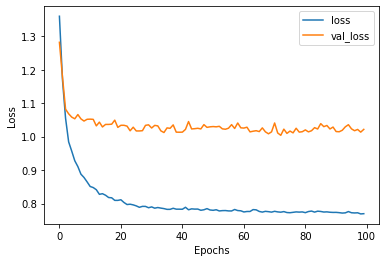

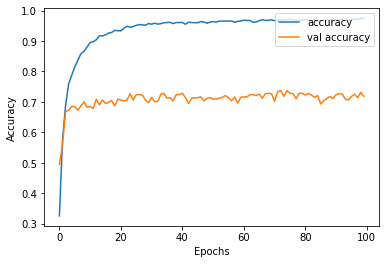

In [51]:
plot_learning_curve(history)

In [52]:
test_x = tokenizer(
    text=test['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y=ytest
)

21/21 [==============================] - ETA: 0s - loss: 1.1210 - accuracy: 0.62 - ETA: 0s - loss: 1.1229 - accuracy: 0.62 - ETA: 0s - loss: 1.0580 - accuracy: 0.68 - ETA: 0s - loss: 1.0450 - accuracy: 0.70 - ETA: 0s - loss: 1.0452 - accuracy: 0.69 - ETA: 0s - loss: 1.0599 - accuracy: 0.67 - ETA: 0s - loss: 1.0639 - accuracy: 0.67 - ETA: 0s - loss: 1.0518 - accuracy: 0.68 - ETA: 0s - loss: 1.0571 - accuracy: 0.68 - ETA: 0s - loss: 1.0459 - accuracy: 0.69 - ETA: 0s - loss: 1.0558 - accuracy: 0.68 - 4s 190ms/step - loss: 1.0558 - accuracy: 0.6858


In [53]:
model_eval

[1.0558159351348877, 0.6858475804328918]

In [54]:
def prediction(model,tokenizer,input_string):
    
    padded_tokens = tokenizer(
    text=[input_string],
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
    
    prediction = model.predict(padded_tokens['input_ids'])
    print(prediction)
    conversion_dict = {0:'joy',1:'fear',2:'anger',3:'sadness'}
    
    return conversion_dict[np.argmax(prediction)]

In [55]:
prediction(model, tokenizer, 'मै बहुत दुखी हूँ')

[[2.860205e-03 9.872832e-01 7.642305e-05 9.780282e-03]]


'fear'

In [56]:
# i am overjoyed
prediction(model, tokenizer, 'நான் மிகவும் மகிழ்ச்சியடைகிறேன்')

[[0.14309143 0.8089495  0.01307027 0.03488887]]


'fear'

In [57]:
# i am very annoyed at you
prediction(model, tokenizer, 'sono molto seccato con te')

[[0.41849485 0.04891138 0.40663943 0.12595436]]


'joy'

In [58]:
#someone is staring at me
prediction(model, tokenizer, "quelqu'un me regarde")

[[2.9864355e-05 9.9996400e-01 1.9248143e-06 4.1606918e-06]]


'fear'

In [59]:
# i saw a ghost
prediction(model, tokenizer, "j'ai vu un fantôme")

[[1.0876921e-03 9.9884677e-01 2.1867370e-05 4.3627540e-05]]


'fear'